# Imports and Functions

In [1]:
import math 
import matplotlib
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model

import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 4 #0 for 0.5, 1 for isolated, 2 for random, 3 for best, 4 for sim_anneal

global threshold_low
global threshold_high
threshold_low = -500
threshold_high = 0

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zeggholder
    global xx,yy
    global Big_df
    global Big_df_land
    global clf


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = MLPClassifier(alpha=0.3, max_iter=3000, solver = 'lbfgs')
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zeggholder = []
    eggholdercoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        Zeggholder.append(eggholderColor(eggholdercoords[i],threshold_low,threshold_high))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zeggholder)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [4]:
def StaticPen(x):

    if(wales.contains_point(x)):
        pen = 1
    else:
        pen = 0

    dist = (tree.query([x], k=1)[0])
    prob = clf.predict_proba([x])[0][0]
    tmp_score = (0.5-np.abs(0.5-prob))*dist

    return tmp_score*pen

def sim_anneal_best():
    
    global tree
    
    tree = KDTree(X, leaf_size=40)

    lower_bound = np.array([-5,-2])
    upper_bound = np.array([51,53])
    max_iter = 1000
    stdevscale = 0.2*(upper_bound-lower_bound)
    gamma = 0.35
    t_initial = 1000
    r = 100
    beta = 1

    import math
    from scipy.stats import truncnorm
    global Xdash,Ydash




    Xbest = np.random.uniform(low  = lower_bound,    
                          high = upper_bound,        
                          size = (len(lower_bound)))

    Ybest = StaticPen(Xbest)
    Xcenter = Xbest                                          
    Ycenter = Ybest
    t_k=t_initial

    for k in range(max_iter-1):  

        Xdash = truncnorm.rvs((lower_bound - Xcenter)/stdevscale,(upper_bound-Xcenter)    
                              /stdevscale,loc=Xcenter,scale=stdevscale)          

        Ydash = StaticPen(Xdash)
        deltaY = Ydash - Ycenter

        if deltaY<=0 or np.random.rand()<min((math.exp(-deltaY/t_k)),1):
            Xcenter = Xdash
            Ycenter = Ydash                               

            if Ydash>Ybest:
                Xbest=Xdash
                Ybest=Ydash

                t_k = t_k*gamma    

    ax.scatter(Xbest[0],Xbest[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
    print('sim_anneal_isolated coord:',(Xbest[0],Xbest[1]),'distance:',Ybest)
    
    return np.array([Xbest[0],Xbest[1]])

In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

In [7]:
def xnew(x): 
    return (-512+(((x+5)*(512--512))/(51+5)))
def ynew(y): 
    return (-512+(((y+2)*(512--512))/(53+2)))

def eggholder(x):
       
    return (-(x[1]+47)*(math.sin(math.sqrt(abs((x[0]/2)+(x[1]+47))))))-((x[0])*(math.sin(math.sqrt(abs((x[0])+(x[1]+47))))))

def eggholderColor(x, threshold_low, threshold_high):
    
    if threshold_low < eggholder((xnew(x[0]),xnew(x[1]))) <threshold_high:
        return 1
    else:
        return 0

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


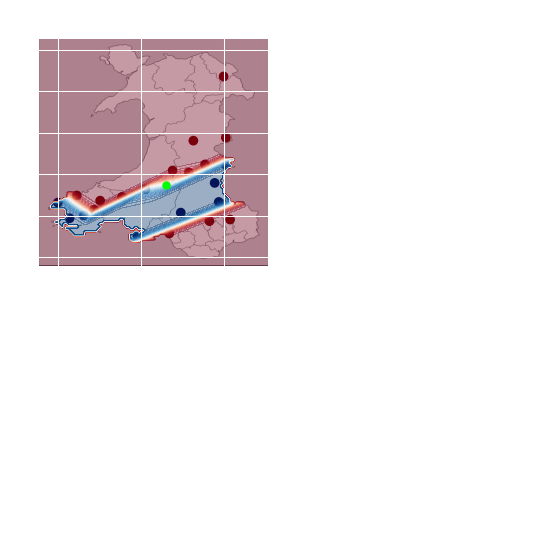

iteration  1
Accuracy is 0.5045183618534897
sim_anneal_isolated coord: (19.086360008328644, 5.271949489353987) distance: [[5.58735468]]
iteration  2
Accuracy is 0.5210536435300903
sim_anneal_isolated coord: (39.825747226121294, 43.58039248612288) distance: [[15.70338201]]
iteration  3
Accuracy is 0.5398961738127284
sim_anneal_isolated coord: (32.53955935803735, 28.112706121680286) distance: [[8.13795339]]
iteration  4
Accuracy is 0.5216304556815997
sim_anneal_isolated coord: (4.4703234328806865, 14.904378507114847) distance: [[7.56560257]]
iteration  5
Accuracy is 0.5125937319746202
sim_anneal_isolated coord: (37.67498003699097, 17.936853809722063) distance: [[4.65412414]]
iteration  6
Accuracy is 0.5110555662372621
sim_anneal_isolated coord: (36.411792765228476, 8.730063341384232) distance: [[1.22249834]]
iteration  7
Accuracy is 0.510286483368583
sim_anneal_isolated coord: (21.01925507619002, 16.421283230738865) distance: [[4.7606695]]
iteration  8
Accuracy is 0.5137473562776389
sim_

<IPython.core.display.Javascript object>


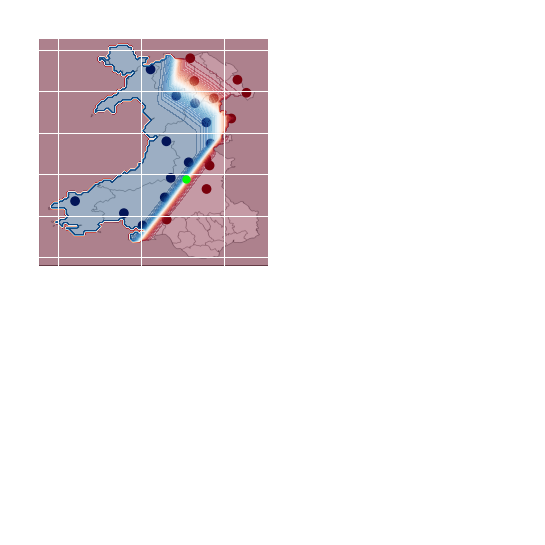

iteration  1
Accuracy is 0.5370121130551817
sim_anneal_isolated coord: (22.232529949055717, 45.27755274116833) distance: [[17.01982227]]
iteration  2
Accuracy is 0.5262449528936743
sim_anneal_isolated coord: (26.04207796364993, 27.950430772719876) distance: [[8.83445749]]
iteration  3
Accuracy is 0.5031724668333013
sim_anneal_isolated coord: (15.801199330372295, 10.651366465832796) distance: [[5.10403757]]
iteration  4
Accuracy is 0.5006729475100942
sim_anneal_isolated coord: (35.71207121052977, 16.47297386507546) distance: [[2.57891539]]
iteration  5
Accuracy is 0.5137473562776389
sim_anneal_isolated coord: (27.100538600260464, 19.150339151008467) distance: [[3.93309435]]
iteration  6
Accuracy is 0.5056719861565083
sim_anneal_isolated coord: (36.450167884209996, 22.13198344815055) distance: [[2.13656617]]
iteration  7
Accuracy is 0.5089405883483945
sim_anneal_isolated coord: (45.32111086994656, 39.64364390115831) distance: [[5.56711902]]
iteration  8
Accuracy is 0.5062487983080177
sim

<IPython.core.display.Javascript object>


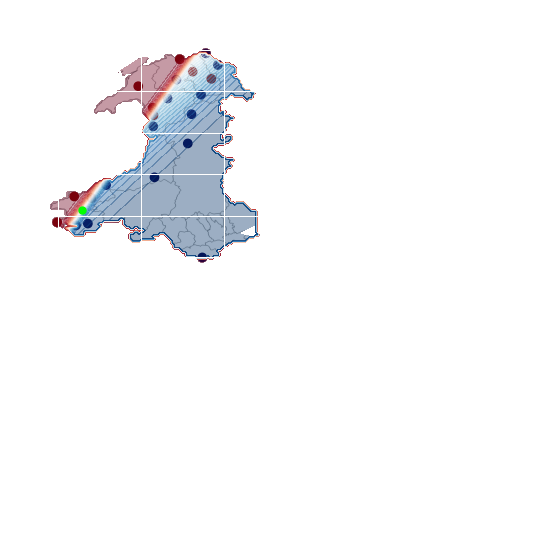

iteration  1
Accuracy is 0.4975966160353778
sim_anneal_isolated coord: (7.128366833401709, 8.141717444413164) distance: [[15.2355983]]
iteration  2
Accuracy is 0.485483560853682
sim_anneal_isolated coord: (19.264239631628836, 41.22526467459633) distance: [[7.57301441]]
iteration  3
Accuracy is 0.5127860026917901
sim_anneal_isolated coord: (32.100197518408784, 34.48856111134363) distance: [[3.52590548]]
iteration  4
Accuracy is 0.49586617958084983
sim_anneal_isolated coord: (11.519831490679554, 17.419181250247327) distance: [[4.91559393]]
iteration  5
Accuracy is 0.5049029032878293
sim_anneal_isolated coord: (22.853005306061295, 31.5615414100868) distance: [[3.33944995]]
iteration  6
Accuracy is 0.5004806767929244
sim_anneal_isolated coord: (26.333457494984458, 38.26244420497838) distance: [[2.87699592]]
iteration  7
Accuracy is 0.4737550471063257
sim_anneal_isolated coord: (29.262881708042173, 47.714112672217844) distance: [[3.45253508]]
iteration  8
Accuracy is 0.4993270524899058
sim_

<IPython.core.display.Javascript object>


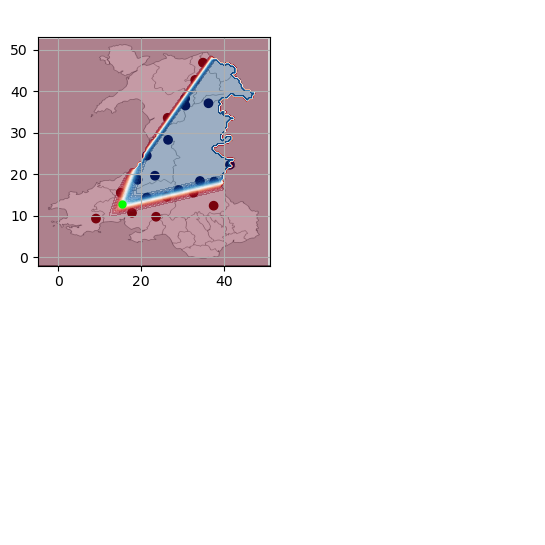

iteration  1
Accuracy is 0.5022111132474524
sim_anneal_isolated coord: (41.35067104258527, 22.311741171023563) distance: [[4.83560779]]
iteration  2
Accuracy is 0.5022111132474524
sim_anneal_isolated coord: (23.552847030869017, 9.783534810577208) distance: [[3.76398504]]
iteration  3
Accuracy is 0.4860603730051913
sim_anneal_isolated coord: (9.086602989534468, 9.342930891804127) distance: [[0.55393111]]
iteration  4
Accuracy is 0.48413766583349355
sim_anneal_isolated coord: (15.056149929202373, 15.59114185397513) distance: [[3.19363769]]
iteration  5
Accuracy is 0.5000961353585849
sim_anneal_isolated coord: (32.57980058059157, 15.577149537857117) distance: [[2.62216008]]
iteration  6
Accuracy is 0.48490674870217265
sim_anneal_isolated coord: (34.13442368156258, 18.397478026265993) distance: [[1.44470919]]
iteration  7
Accuracy is 0.499134781772736
sim_anneal_isolated coord: (36.17887098649461, 37.116645648190726) distance: [[3.59296848]]
iteration  8
Accuracy is 0.47106325706594887
sim

<IPython.core.display.Javascript object>


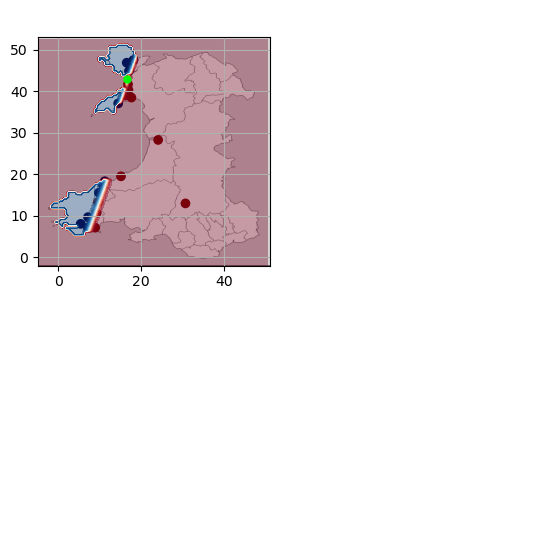

iteration  1
Accuracy is 0.5177850413382042
sim_anneal_isolated coord: (5.403298086117573, 8.069401040888323) distance: [[12.58509798]]
iteration  2
Accuracy is 0.5431647760046145
sim_anneal_isolated coord: (24.056419104444203, 28.285105444677917) distance: [[8.09685425]]
iteration  3
Accuracy is 0.537588925206691
sim_anneal_isolated coord: (15.108419071673682, 19.526008522575935) distance: [[5.04779129]]
iteration  4
Accuracy is 0.5304749086714093
sim_anneal_isolated coord: (17.615990353422223, 38.48907347457118) distance: [[3.49475906]]
iteration  5
Accuracy is 0.523937704287637
sim_anneal_isolated coord: (14.436742635177868, 37.074910256392165) distance: [[0.81609779]]
iteration  6
Accuracy is 0.5260526821765045
sim_anneal_isolated coord: (8.885316539488578, 7.15990059422823) distance: [[0.95287864]]
iteration  7
Accuracy is 0.5243222457219765
sim_anneal_isolated coord: (9.78527331225473, 15.559865338042972) distance: [[2.44943699]]
iteration  8
Accuracy is 0.5254758700249952
sim_an

<IPython.core.display.Javascript object>


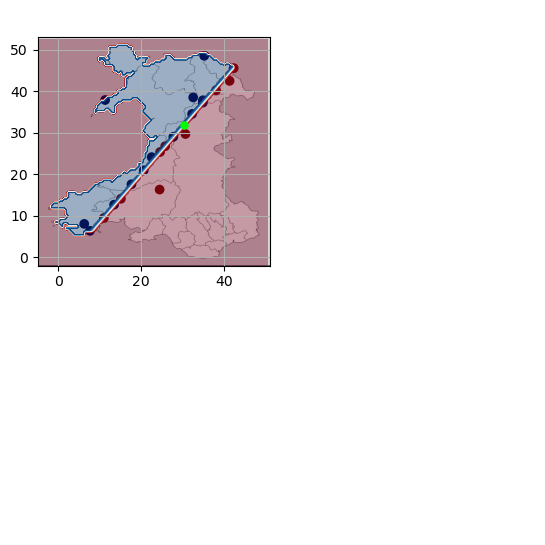

iteration  1
Accuracy is 0.47510094212651416
sim_anneal_isolated coord: (11.289275572198225, 37.90034776411901) distance: [[11.44790826]]
iteration  2
Accuracy is 0.49048259950009615
sim_anneal_isolated coord: (30.64463150954571, 29.71576753894807) distance: [[6.15182901]]
iteration  3
Accuracy is 0.5164391463180158
sim_anneal_isolated coord: (6.256242322458213, 8.066136596752905) distance: [[9.33137931]]
iteration  4
Accuracy is 0.522207267833109
sim_anneal_isolated coord: (32.50355948904383, 38.52945559324401) distance: [[4.06334728]]
iteration  5
Accuracy is 0.5127860026917901
sim_anneal_isolated coord: (15.08700669073636, 14.111096950036023) distance: [[4.29528643]]
iteration  6
Accuracy is 0.5133628148432994
sim_anneal_isolated coord: (22.497206435085165, 24.146862612799076) distance: [[3.47365051]]
iteration  7
Accuracy is 0.5052874447221688
sim_anneal_isolated coord: (41.264441041347176, 42.507517135576165) distance: [[3.74736677]]
iteration  8
Accuracy is 0.5108632955200922
sim

<IPython.core.display.Javascript object>


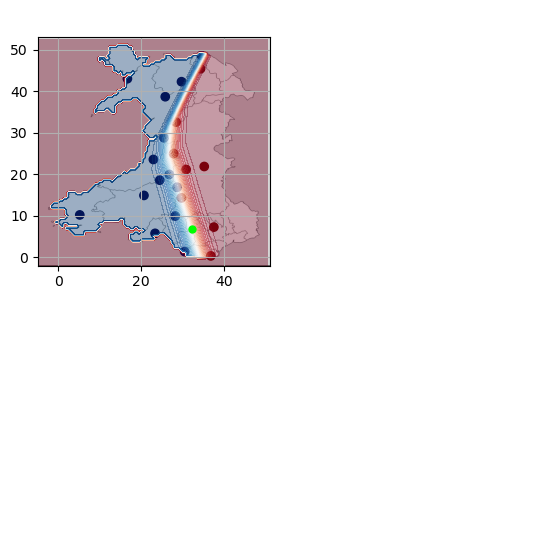

iteration  1
Accuracy is 0.5323976158431071
sim_anneal_isolated coord: (23.318825401780877, 5.786781660057379) distance: [[8.23100259]]
iteration  2
Accuracy is 0.5125937319746202
sim_anneal_isolated coord: (37.48082894153553, 7.291045299726858) distance: [[6.97563878]]
iteration  3
Accuracy is 0.5254758700249952
sim_anneal_isolated coord: (16.651397999734428, 43.03185142322185) distance: [[8.82410899]]
iteration  4
Accuracy is 0.5418188809844261
sim_anneal_isolated coord: (25.769652225354207, 38.694727762924124) distance: [[4.80576835]]
iteration  5
Accuracy is 0.5362430301865025
sim_anneal_isolated coord: (29.67786463160672, 14.321324550774555) distance: [[4.65576279]]
iteration  6
Accuracy is 0.5335512401461258
sim_anneal_isolated coord: (34.268961751160205, 45.43825072144852) distance: [[4.93028059]]
iteration  7
Accuracy is 0.5441261295904634
sim_anneal_isolated coord: (27.787313642674565, 24.971653186268203) distance: [[3.95630518]]
iteration  8
Accuracy is 0.5437415881561238
sim

<IPython.core.display.Javascript object>


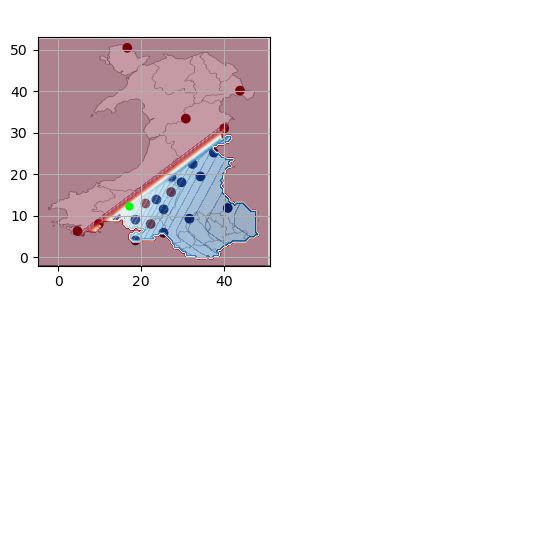

iteration  1
Accuracy is 0.46837146702557203
sim_anneal_isolated coord: (16.61905059686875, 50.46762208272861) distance: [[22.02530401]]
iteration  2
Accuracy is 0.4614497212074601
sim_anneal_isolated coord: (30.729618551223624, 33.41770134123851) distance: [[10.98742023]]
iteration  3
Accuracy is 0.4887521630455682
sim_anneal_isolated coord: (22.248199394559016, 8.025817054102747) distance: [[6.60639442]]
iteration  4
Accuracy is 0.4950970967121707
sim_anneal_isolated coord: (43.767097703237674, 40.16236650421161) distance: [[6.49996793]]
iteration  5
Accuracy is 0.5010574889444338
sim_anneal_isolated coord: (31.60069931437167, 9.313417668570885) distance: [[4.64801358]]
iteration  6
Accuracy is 0.493174389540473
sim_anneal_isolated coord: (34.232587948268176, 19.491480427998322) distance: [[3.3700406]]
iteration  7
Accuracy is 0.4902903287829264
sim_anneal_isolated coord: (39.969930281292804, 31.07408521848825) distance: [[3.82124487]]
iteration  8
Accuracy is 0.4879830801768891
sim_

<IPython.core.display.Javascript object>


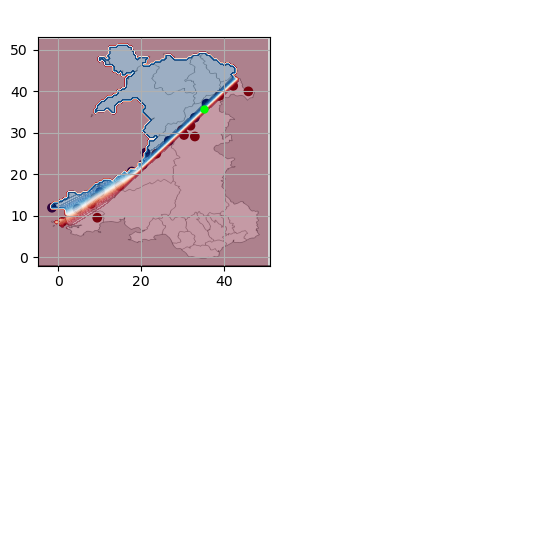

iteration  1
Accuracy is 0.5070178811766968
sim_anneal_isolated coord: (35.70759946012264, 37.03211432140735) distance: [[3.62950238]]
iteration  2
Accuracy is 0.5049029032878293
sim_anneal_isolated coord: (9.390386544623581, 9.553574653056781) distance: [[9.35606222]]
iteration  3
Accuracy is 0.5018265718131129
sim_anneal_isolated coord: (14.72762207081321, 17.248032116974283) distance: [[4.61806007]]
iteration  4
Accuracy is 0.4979811574697174
sim_anneal_isolated coord: (45.79396067636968, 39.98128978700233) distance: [[3.29857051]]
iteration  5
Accuracy is 0.4952893674293405
sim_anneal_isolated coord: (26.616669862503812, 28.070564729606104) distance: [[2.64225114]]
iteration  6
Accuracy is 0.49817342818688715
sim_anneal_isolated coord: (10.066169954599655, 15.691882742984879) distance: [[2.17260636]]
iteration  7
Accuracy is 0.49971159392424536
sim_anneal_isolated coord: (0.943585628808421, 8.533540162194015) distance: [[1.87666051]]
iteration  8
Accuracy is 0.49009805806575657
sim

<IPython.core.display.Javascript object>


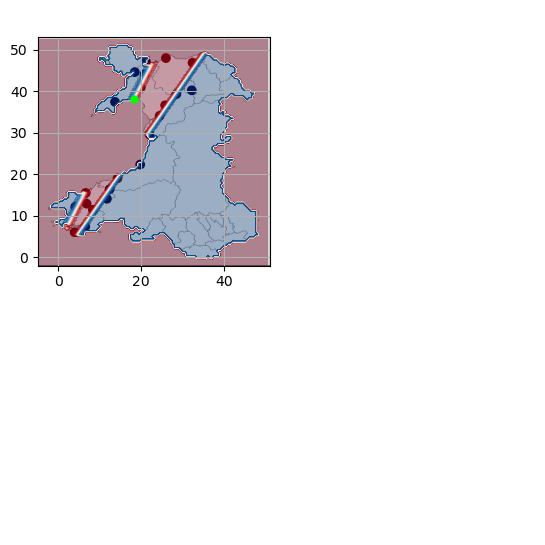

iteration  1
Accuracy is 0.5325898865602768
sim_anneal_isolated coord: (19.734204198072426, 22.349577548107707) distance: [[0.81521371]]
iteration  2
Accuracy is 0.5089405883483945
sim_anneal_isolated coord: (3.9489874928244353, 6.064865250758442) distance: [[7.38635969]]
iteration  3
Accuracy is 0.5031724668333013
sim_anneal_isolated coord: (32.15902482912271, 40.237073518663635) distance: [[0.99280023]]
iteration  4
Accuracy is 0.5024033839646221
sim_anneal_isolated coord: (11.71410405133207, 14.11890799750273) distance: [[4.86983093]]
iteration  5
Accuracy is 0.5052874447221688
sim_anneal_isolated coord: (25.929219568761507, 47.998166119446104) distance: [[3.18490061]]
iteration  6
Accuracy is 0.5012497596616036
sim_anneal_isolated coord: (19.874797142580363, 40.905566629915455) distance: [[1.59333309]]
iteration  7
Accuracy is 0.49951932320707554
sim_anneal_isolated coord: (21.98750299246734, 29.601556051809816) distance: [[3.09568916]]
iteration  8
Accuracy is 0.49778888675254757


<IPython.core.display.Javascript object>


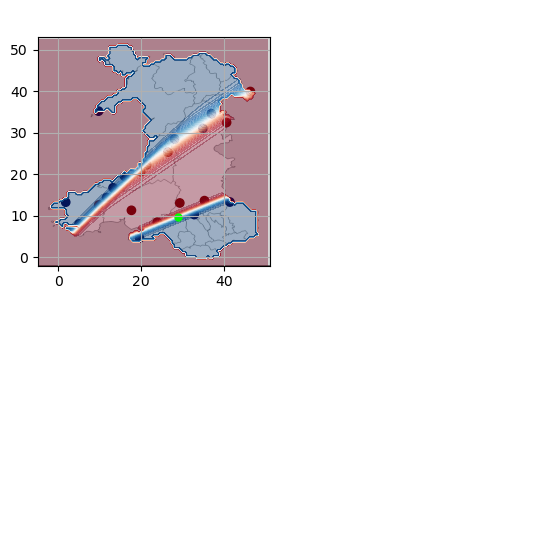

iteration  1
Accuracy is 0.4843299365506633
sim_anneal_isolated coord: (28.019398529803247, 28.497028609021285) distance: [[9.1197953]]
iteration  2
Accuracy is 0.4870217265910402
sim_anneal_isolated coord: (41.34909767160094, 13.332540440091242) distance: [[7.13233828]]
iteration  3
Accuracy is 0.4975966160353778
sim_anneal_isolated coord: (40.54313948289039, 32.489625565223776) distance: [[5.63395268]]
iteration  4
Accuracy is 0.5037492789848106
sim_anneal_isolated coord: (29.274126868296264, 13.1045382180144) distance: [[5.54841304]]
iteration  5
Accuracy is 0.5020188425302826
sim_anneal_isolated coord: (23.84142384458443, 8.479100243675331) distance: [[2.88982275]]
iteration  6
Accuracy is 0.4983656989040569
sim_anneal_isolated coord: (35.21502730841777, 13.668815325442086) distance: [[2.38465141]]
iteration  7
Accuracy is 0.4972120746010383
sim_anneal_isolated coord: (9.764019923452993, 12.620196069817773) distance: [[2.42253192]]
iteration  8
Accuracy is 0.48894443376273794
sim_a

<IPython.core.display.Javascript object>


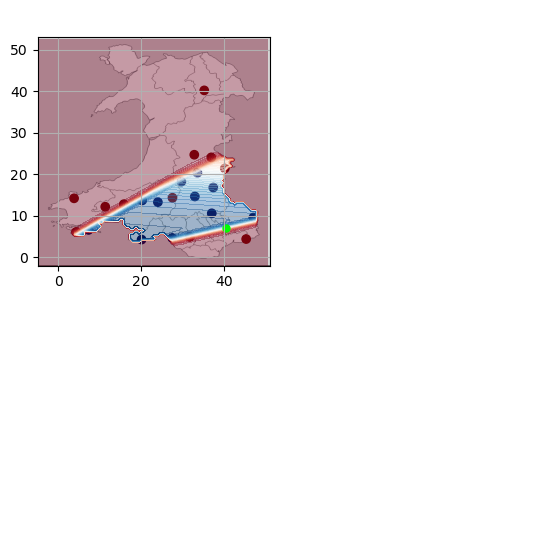

iteration  1
Accuracy is 0.49855796962122667
sim_anneal_isolated coord: (32.76348138833298, 24.72134809176206) distance: [[4.0175822]]
iteration  2
Accuracy is 0.4987502403383965
sim_anneal_isolated coord: (20.207597911354252, 13.716085802885079) distance: [[3.3453156]]
iteration  3
Accuracy is 0.5191309363583926
sim_anneal_isolated coord: (40.10952370992294, 21.420112451600872) distance: [[1.04702561]]
iteration  4
Accuracy is 0.5150932512978273
sim_anneal_isolated coord: (3.8090868259648403, 14.22476067888634) distance: [[6.85059044]]
iteration  5
Accuracy is 0.5093251297827341
sim_anneal_isolated coord: (11.313313091844655, 12.1959233556013) distance: [[3.56228014]]
iteration  6
Accuracy is 0.5062487983080177
sim_anneal_isolated coord: (27.506232835490543, 14.362662726914177) distance: [[0.75337627]]
iteration  7
Accuracy is 0.4999038646414151
sim_anneal_isolated coord: (7.299299040105744, 6.616678526219683) distance: [[2.71537122]]
iteration  8
Accuracy is 0.5052874447221688
sim_an

<IPython.core.display.Javascript object>


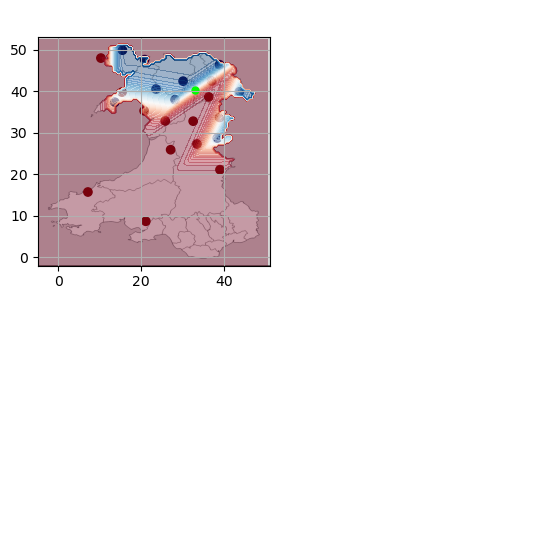

iteration  1
Accuracy is 0.47279369352047684
sim_anneal_isolated coord: (7.142970733323292, 15.74229488787622) distance: [[15.85871653]]
iteration  2
Accuracy is 0.46260334551047877
sim_anneal_isolated coord: (21.088145090180294, 8.695506092584328) distance: [[7.79517664]]
iteration  3
Accuracy is 0.4737550471063257
sim_anneal_isolated coord: (27.067293434695223, 25.927619828004456) distance: [[7.79892573]]
iteration  4
Accuracy is 0.4870217265910402
sim_anneal_isolated coord: (38.850893368142124, 46.41034415727401) distance: [[4.64545205]]
iteration  5
Accuracy is 0.47279369352047684
sim_anneal_isolated coord: (20.803717603129435, 47.63010293346657) distance: [[4.96448194]]
iteration  6
Accuracy is 0.5041338204191501
sim_anneal_isolated coord: (38.953810716997815, 21.11671519166395) distance: [[4.64116511]]
iteration  7
Accuracy is 0.5181695827725438
sim_anneal_isolated coord: (38.292391355535365, 28.734877300862117) distance: [[3.27562359]]
iteration  8
Accuracy is 0.4827917708133051

<IPython.core.display.Javascript object>


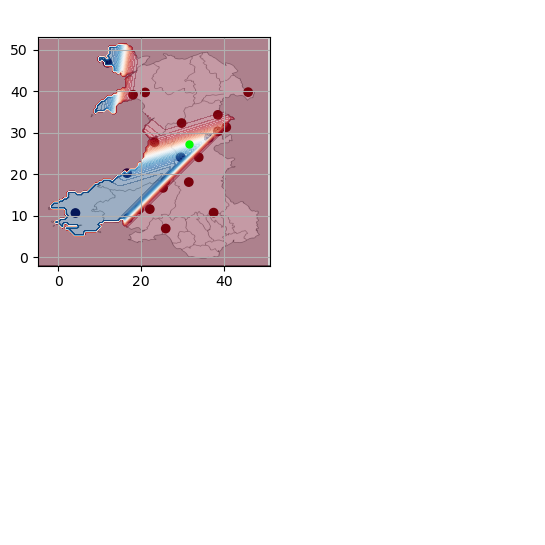

iteration  1
Accuracy is 0.5006729475100942
sim_anneal_isolated coord: (16.79922307500692, 9.416093410702075) distance: [[8.65412538]]
iteration  2
Accuracy is 0.5062487983080177
sim_anneal_isolated coord: (25.883876607401177, 6.945441483567574) distance: [[4.47693815]]
iteration  3
Accuracy is 0.5074024226110363
sim_anneal_isolated coord: (31.44121412360081, 18.133745301910295) distance: [[3.09706817]]
iteration  4
Accuracy is 0.510286483368583
sim_anneal_isolated coord: (36.278627480256176, 28.79150369545951) distance: [[3.7344717]]
iteration  5
Accuracy is 0.5062487983080177
sim_anneal_isolated coord: (22.050724286204662, 11.623768743192741) distance: [[2.38258041]]
iteration  6
Accuracy is 0.505095174004999
sim_anneal_isolated coord: (33.83811528093431, 24.104208021493626) distance: [[1.29887652]]
iteration  7
Accuracy is 0.50432609113632
sim_anneal_isolated coord: (25.24799265690463, 16.741543238983716) distance: [[2.66011269]]
iteration  8
Accuracy is 0.5045183618534897
sim_annea

<IPython.core.display.Javascript object>


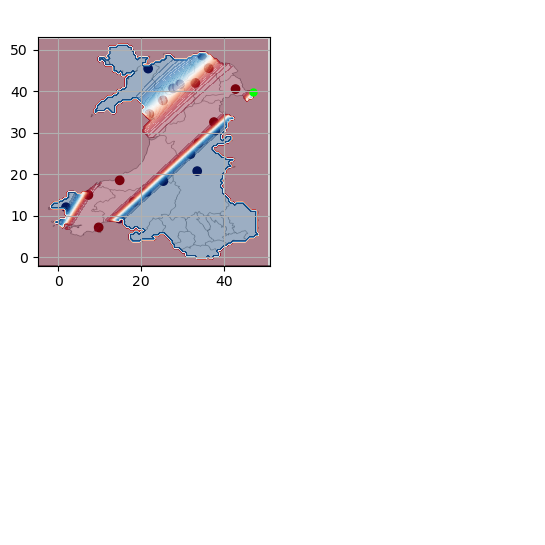

iteration  1
Accuracy is 0.46241107479330895
sim_anneal_isolated coord: (21.649623198554004, 45.46905584307649) distance: [[11.97162914]]
iteration  2
Accuracy is 0.517977312055374
sim_anneal_isolated coord: (42.69749604559596, 40.53724513374192) distance: [[9.46085015]]
iteration  3
Accuracy is 0.5029801961161315
sim_anneal_isolated coord: (21.93979703266172, 34.5101593906783) distance: [[5.41874696]]
iteration  4
Accuracy is 0.5150932512978273
sim_anneal_isolated coord: (34.64833991461993, 48.62529549119516) distance: [[5.60240274]]
iteration  5
Accuracy is 0.5049029032878293
sim_anneal_isolated coord: (25.30887916941935, 18.3756443311904) distance: [[4.20884529]]
iteration  6
Accuracy is 0.5079792347625457
sim_anneal_isolated coord: (9.730047620894325, 7.225321980903563) distance: [[5.67291106]]
iteration  7
Accuracy is 0.49701980388386846
sim_anneal_isolated coord: (37.500941247201965, 32.58607979482484) distance: [[3.85246529]]
iteration  8
Accuracy is 0.5010574889444338
sim_annea

<IPython.core.display.Javascript object>


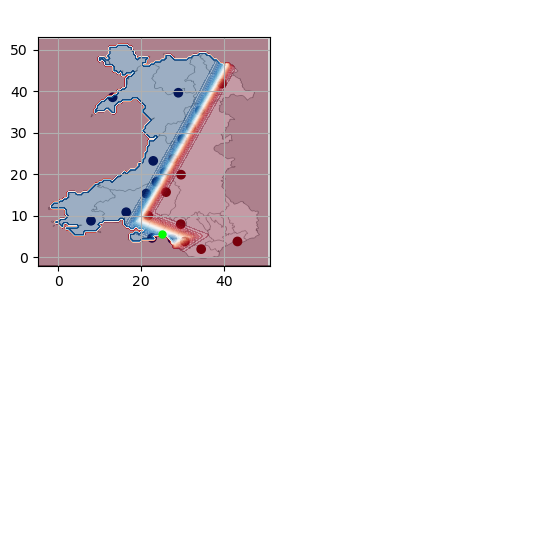

iteration  1
Accuracy is 0.5064410690251875
sim_anneal_isolated coord: (39.414548248410526, 41.85895581820015) distance: [[12.80240967]]
iteration  2
Accuracy is 0.5295135550855604
sim_anneal_isolated coord: (7.882646820765533, 8.819102640181484) distance: [[7.09363525]]
iteration  3
Accuracy is 0.5460488367621611
sim_anneal_isolated coord: (22.872203775781948, 23.240597337132886) distance: [[6.87903316]]
iteration  4
Accuracy is 0.5391270909440492
sim_anneal_isolated coord: (22.575935382251195, 4.696409337148278) distance: [[3.54005893]]
iteration  5
Accuracy is 0.5448952124591425
sim_anneal_isolated coord: (28.918717635235524, 39.652093165353115) distance: [[4.78620792]]
iteration  6
Accuracy is 0.5327821572774466
sim_anneal_isolated coord: (29.88640373449653, 28.447495337326718) distance: [[2.13669657]]
iteration  7
Accuracy is 0.5160546048836763
sim_anneal_isolated coord: (29.572788492971096, 19.917133927542803) distance: [[3.60180569]]
iteration  8
Accuracy is 0.5275908479138627
s

<IPython.core.display.Javascript object>


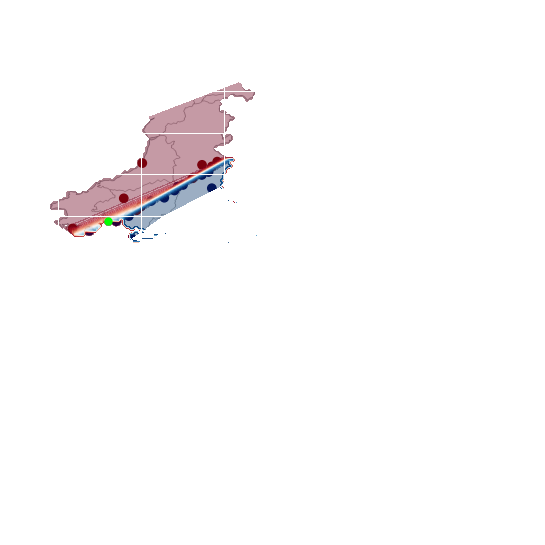

iteration  1
Accuracy is 0.5147087098634878
sim_anneal_isolated coord: (36.98771152669966, 16.66161234773895) distance: [[10.55006842]]
iteration  2
Accuracy is 0.5154777927321669
sim_anneal_isolated coord: (20.2400413815201, 22.707956305198053) distance: [[7.1807111]]
iteration  3
Accuracy is 0.49663526244952894
sim_anneal_isolated coord: (15.782691763743372, 14.220094679289534) distance: [[1.97737204]]
iteration  4
Accuracy is 0.49740434531820804
sim_anneal_isolated coord: (34.630726892149355, 22.291151939482255) distance: [[2.89509196]]
iteration  5
Accuracy is 0.4987502403383965
sim_anneal_isolated coord: (25.539520365876605, 14.363402924705024) distance: [[4.54907173]]
iteration  6
Accuracy is 0.4993270524899058
sim_anneal_isolated coord: (19.918474918406943, 12.245901864560654) distance: [[2.10848428]]
iteration  7
Accuracy is 0.4983656989040569
sim_anneal_isolated coord: (38.286213976545795, 23.058490239383993) distance: [[1.44523933]]
iteration  8
Accuracy is 0.4989425110555662

<IPython.core.display.Javascript object>


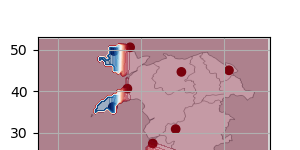

iteration  1
Accuracy is 0.5481638146510287
sim_anneal_isolated coord: (29.65978275817546, 44.678605980751534) distance: [[19.41083543]]
iteration  2
Accuracy is 0.535089405883484
sim_anneal_isolated coord: (13.135344843237865, 36.21631871983346) distance: [[9.2600337]]
iteration  3
Accuracy is 0.5320130744087676
sim_anneal_isolated coord: (25.441628596746718, 20.075596027990606) distance: [[9.45180695]]
iteration  4
Accuracy is 0.5247067871563161
sim_anneal_isolated coord: (41.11681043318542, 45.05542816568008) distance: [[5.28982213]]
iteration  5
Accuracy is 0.535858488752163
sim_anneal_isolated coord: (18.56853931096757, 5.603466132910064) distance: [[7.88652596]]
iteration  6
Accuracy is 0.5322053451259373
sim_anneal_isolated coord: (28.278750829068787, 30.89395544532369) distance: [[4.88177976]]
iteration  7
Accuracy is 0.5206691020957508
sim_anneal_isolated coord: (17.308758490787838, 50.598609415716396) distance: [[5.70418223]]
iteration  8
Accuracy is 0.5147087098634878
sim_an

<IPython.core.display.Javascript object>


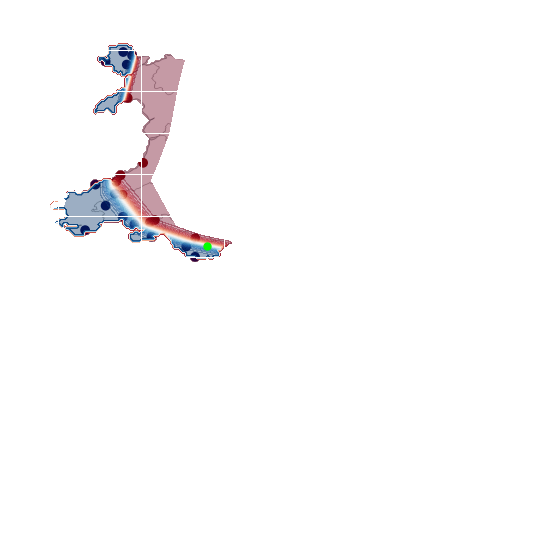

iteration  1
Accuracy is 0.5137473562776389
sim_anneal_isolated coord: (33.00772097437432, 4.622203766430074) distance: [[9.1411919]]
iteration  2
Accuracy is 0.5420111517015959
sim_anneal_isolated coord: (20.440964904677088, 22.778398335065322) distance: [[5.19974579]]
iteration  3
Accuracy is 0.5306671793885791
sim_anneal_isolated coord: (22.07105079646645, 8.471612425086068) distance: [[3.78430636]]
iteration  4
Accuracy is 0.5268217650451836
sim_anneal_isolated coord: (11.410192842249035, 47.190431632436166) distance: [[9.32405487]]
iteration  5
Accuracy is 0.5283599307825418
sim_anneal_isolated coord: (16.716770235486162, 38.404826396375086) distance: [[4.94299329]]
iteration  6
Accuracy is 0.5293212843683907
sim_anneal_isolated coord: (15.488435251701834, 15.100903736327538) distance: [[2.24729636]]
iteration  7
Accuracy is 0.516246875600846
sim_anneal_isolated coord: (8.935105878797765, 17.523170294583444) distance: [[1.99384643]]
iteration  8
Accuracy is 0.5258604114593347
sim_

<IPython.core.display.Javascript object>


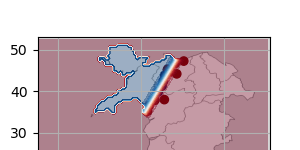

iteration  1
Accuracy is 0.5279753893482023
sim_anneal_isolated coord: (7.757725952238765, 13.157230601511667) distance: [[9.63597827]]
iteration  2
Accuracy is 0.5220149971159392
sim_anneal_isolated coord: (1.6774998366591305, 12.451458528124466) distance: [[2.56164529]]
iteration  3
Accuracy is 0.5233608921361277
sim_anneal_isolated coord: (28.535037282285153, 44.19920186440519) distance: [[1.9070688]]
iteration  4
Accuracy is 0.5266294943280139
sim_anneal_isolated coord: (21.505405395003017, 35.22211978795044) distance: [[2.36022542]]
iteration  5
Accuracy is 0.5266294943280139
sim_anneal_isolated coord: (30.22634653163209, 47.27998092595433) distance: [[0.76527275]]
iteration  6
Accuracy is 0.5287444722168814
sim_anneal_isolated coord: (8.917889584135375, 16.24980939203629) distance: [[1.18245541]]
iteration  7
Accuracy is 0.5293212843683907
sim_anneal_isolated coord: (4.103432610248288, 8.66966555148539) distance: [[1.45963879]]
iteration  8
Accuracy is 0.5291290136512209
sim_anne

<IPython.core.display.Javascript object>


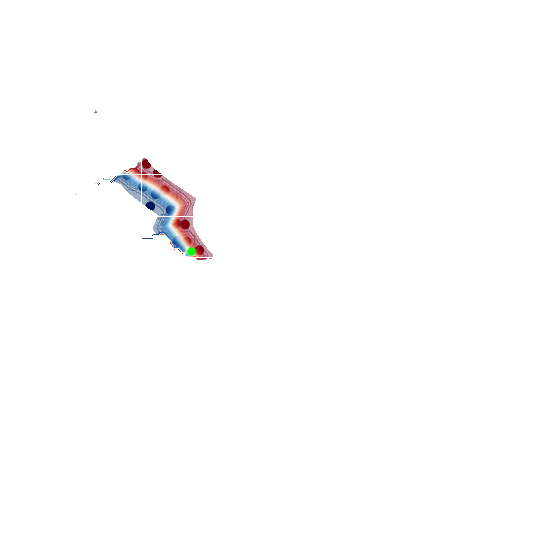

iteration  1
Accuracy is 0.5127860026917901
sim_anneal_isolated coord: (23.99186435931905, 20.3433037571514) distance: [[6.83867697]]
iteration  2
Accuracy is 0.4877908094597193
sim_anneal_isolated coord: (38.89692176286219, 3.1151969258433585) distance: [[9.26006796]]
iteration  3
Accuracy is 0.5131705441261296
sim_anneal_isolated coord: (33.52697873986674, 11.94817747910021) distance: [[3.93097857]]
iteration  4
Accuracy is 0.5035570082676408
sim_anneal_isolated coord: (6.265042803922626, 6.1751339124250855) distance: [[5.31937196]]
iteration  5
Accuracy is 0.5177850413382042
sim_anneal_isolated coord: (16.65685304996518, 19.824276648469713) distance: [[3.13613635]]
iteration  6
Accuracy is 0.5310517208229186
sim_anneal_isolated coord: (22.157480947666798, 12.295255968927584) distance: [[3.10478114]]
iteration  7
Accuracy is 0.5210536435300903
sim_anneal_isolated coord: (33.95909244760475, 1.682117755369278) distance: [[1.89211206]]
iteration  8
Accuracy is 0.5247067871563161
sim_ann

In [8]:
from random import randint
import time

valid_seeds = [12,15,17,21,23,24,25,31,35,36,37,41,43,45,49,52,55,56,57,58,59]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            eggholderColor(landpoints[value],threshold_low,threshold_high)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            elif(selection_model==4):
                nextpoint = sim_anneal_best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], eggholderColor(nextpoint,threshold_low,threshold_high)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [9]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 53.84 %
Improvement is = 2.56 %


In [10]:
np.savetxt('eggholderBestSimAnnealnn', Results)